In [58]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.cluster import KMeans
from random import randint
import matplotlib.pyplot as plt

%matplotlib inline

In [59]:
tweets = pd.read_pickle("../../data/cp_tweets.pkl")

## Abstract
In this notebook, we will determine for each tweet if it belongs to any of these classes:
* Talks about Trump
* Talks about Hillary
* Talks about both
* We couldn't define any of the other groups

This it will be evaluated by checking keywords (hashtags and mentions) on the tweets, these keywords will be our features. Once each tweet is labeled, we can evaluate sentiment analysis or topic analysis, or even compare the data with demographic data, such as population or states.


## Getting the features
We will define a function to extract the features from each tweet. Our features will be hashtags and mentions, we will not distinguish one with another, we will treat them the same way. Therefore, we will remove *#* and *@* from the hashtags and mentions, and from now on, we will call them keywords.

In [60]:
def features(tweet):
    tweet = tweet.lower()
    
    # Get hashtags and mentions with regex
    # I guess we can improve this by taking hashtags and mentions from the API
    tags = re.findall('(^|\s)([@#][\w-]+)', tweet)
    tags = [item[1] for item in tags]
    
    #Remove mentions and hashtags symbols
    tags = list(map(lambda item: item
                     .replace('@', '')
                     .replace('#',''), tags))
    
    # Remove repetitive elements
    tags = list(set(tags))
    
    # If the list is empty, return a NaN
    return tags if tags else np.nan

We apply the function for each tweet and afterwards, remove those tweets that do not have any keywords.

In [61]:
kw = tweets.text.apply(features)
kw.dropna(inplace=True)

In [62]:
print(kw.head(10))
print("\nWe reduce the dataset from",len(tweets), "to", len(kw))

0                               [theblaze, realdonaldtrump]
1         [barackobama, trumppence, fbi, realdonaldtrump...
10                           [realdonaldtrump, mike4193496]
100       [joenbc, mike_pence, williegeist, morningmika,...
1000                                      [realdonaldtrump]
10000     [realdonaldtrump, barackobama, grammybijou3, i...
100000    [radicalrw, barackobama, cr, mikemckenna19, hi...
100001      [dt, trumpers, foxnews, tnuts, realdonaldtrump]
100002      [realdonaldtrump, melaniatrump, hillaryclinton]
100003        [bigduhie1955, supportourtroopsandvets, maga]
Name: text, dtype: object

We reduce the dataset from 657307 to 597024


We define a function that given *n* will give us a list of the *n* most common keywords. This list will be used to build a binary matrix.

In [63]:
def getNKeywords(kw, n):
    output = []
    dic = Counter()
    for key, keywords in kw.iteritems():
        for k in keywords: dic[k] += 1
            
    output = sorted(dic, key=dic.__getitem__, reverse=True)
    return output[:n]

# Getting the N most common keywords
all_keywords = getNKeywords(kw, 50)
print(all_keywords)

['realdonaldtrump', 'hillaryclinton', 'trump', 'foxnews', 'cnn', 'nevertrump', 'maga', 'imwithher', 'neverhillary', 'hillary', 'trumppence16', 'donaldtrump', 'crookedhillary', 'seanhannity', 'kellyannepolls', 'msnbc', 'potus', 'gop', 'trumptrain', 'epn', 'nytimes', 'politico', 'mike_pence', 'reince', 'morning_joe', 'dumptrump', 'makeamericagreatagain', 'danscavino', 'erictrump', 'trump2016', 'donaldjtrumpjr', 'abc', 'basketofdeplorables', 'cnnpolitics', 'barackobama', 'greta', 'teamtrump', 'billclinton', 'timkaine', 'loudobbs', 'morningmika', 'tcot', 'rogerjstonejr', 'ingrahamangle', 'maddow', 'katrinapierson', 'washingtonpost', 'speakerryan', 'hfa', 'anncoulter']


# Building a binary matrix
In order to fit the clustering method, we will need a matrix $N x M$ and right now what we have so far is a list of list which the inside list has different lenght. That is the reason we will build a binary matrix where each row is a tweet and each column is a keyword from the list extracted before. The cell will indicated if that tweet has that keyword (True) or not (False).

In [64]:
matrix = kw.apply(lambda items : np.array([keyword in items for keyword in all_keywords]))

If the tweet does not contain any keyword as we reduced the total keywords that we have, then we will remove it.

In [65]:
reduced_matrix = matrix.apply(lambda x : x if True in x else np.nan)
reduced_matrix.dropna(inplace=True)
print("\nWe reduce the dataset from",matrix.shape[0], "to", reduced_matrix.shape[0])


We reduce the dataset from 597024 to 573745


## K-means
Out main goal is to classify a tweet in these 4 groups:
* Talks about Trump
* Talks about Hillary
* Talks about both
* It's not relevant
    
For that, we will use a clustering method, K-means. K-means is a method for cluster analysis where you can give the number of cluster you want and it defines centroids which determine the 'middle' of a group (or class). This method normally even the clusters size which is not our case as we want 4 groups were the big one it will be the one that talks about Trump. Therefore, we decided to apply K-means but with *n_clusters* bigger than 4, let's say 15 and then we can classify manually if the cluster talks about Trump, Hillary or both.

We should not forget we are trying to divide keywords (hashtags and mentions mainly) into groups, so each group will have a 'top-5' keywords that are used from that class. Once we know which are the most common keywords for each group, we can decide who are they talking about.

In [66]:
cluster = KMeans(n_clusters=20, random_state=0, algorithm='full').fit(reduced_matrix.tolist())

## What the centroids tell us
The centroids from the clustering will tell us what is the proability for each hashtag that appears in the tweets from that cluster. In orther words if the hashtag has a value of 1 that means that that hashtag appears in all the tweets from that group. The same if we have 0.45, there is a 45% chance that the hashtag appear in a selected random tweet from that group.

In [67]:
cluster.cluster_centers_[0]

array([ 3.48088752e-01,  1.00000000e+00,  7.68892794e-03,  1.00000000e+00,
        5.83560977e-15,  1.53778559e-03,  2.96572935e-03,  7.68892794e-04,
        3.62478032e-03,  2.52636204e-03,  2.52636204e-03,  2.19683656e-03,
        3.07557118e-03,  1.59270650e-02,  1.25219684e-02,  8.12829525e-03,
        1.17530756e-02,  3.40509666e-03,  1.09841828e-03,  6.59050967e-04,
        4.17398946e-03,  1.20826011e-03,  5.60193322e-03,  2.63620387e-03,
        7.68892794e-04,  2.19683656e-04,  1.86731107e-03,  8.78734622e-04,
        7.46924429e-03,  3.29525483e-04,  4.50351494e-03,  1.39499121e-02,
        3.18541301e-03,  5.27240773e-03,  1.60369069e-02,  1.64762742e-02,
        1.42794376e-03,  1.13137083e-02,  1.86731107e-03,  2.96572935e-03,
        3.29525483e-04, -8.75167994e-16,  9.80118764e-17,  5.82161687e-03,
        1.31810193e-03,  1.20826011e-03,  5.49209139e-04,  1.31810193e-03,
        7.68892794e-04,  1.31810193e-03])

As we see in the first centroid, there is a probability of 1 that 'realdonaldtrump' appears on the tweets from that cluster and there is low chance for 'hillaryclinton', 'foxnews', 'cnn', 'nevertrump', 'maga', 'imwithher' appearing. The order preserved in the centroids is the same as the variable *all_keywords*, that is how we know which keyword belongs each number.

We have to define a threshold to determine which keywords are significant for each class, this is just to visualise and clarify what is the cluster talking about, but the K-means algorithm is already applied. 'Undefined group' means the class that doesn't have any significant keywords.

In [68]:
p = 0.95 # Threshold probability. It will give us the hashtags that its chance is bigger than p.
c = 0
clusters = {}
counters = Counter(cluster.labels_)
for center in cluster.cluster_centers_:
    s = pd.Series(center)
    idxs = s[s>=p].index
    clusters[c] = {}
    clusters[c]['keywords'] = [all_keywords[i] for i in idxs] if idxs.tolist() else 'Undefined group'
    clusters[c]['tweets'] = counters[c] 
    c+=1
        
clusters

{0: {'keywords': ['hillaryclinton', 'foxnews'], 'tweets': 9104},
 1: {'keywords': ['hillaryclinton'], 'tweets': 108540},
 2: {'keywords': ['realdonaldtrump'], 'tweets': 250243},
 3: {'keywords': ['trump'], 'tweets': 47681},
 4: {'keywords': ['trumppence16'], 'tweets': 10517},
 5: {'keywords': ['maga'], 'tweets': 12087},
 6: {'keywords': ['donaldtrump'], 'tweets': 9925},
 7: {'keywords': ['imwithher'], 'tweets': 12230},
 8: {'keywords': ['realdonaldtrump', 'hillaryclinton'], 'tweets': 22131},
 9: {'keywords': ['nevertrump'], 'tweets': 14281},
 10: {'keywords': ['neverhillary'], 'tweets': 11697},
 11: {'keywords': 'Undefined group', 'tweets': 11825},
 12: {'keywords': ['hillary'], 'tweets': 9479},
 13: {'keywords': ['hillaryclinton', 'cnn'], 'tweets': 5759},
 14: {'keywords': ['cnn'], 'tweets': 11894},
 15: {'keywords': ['seanhannity'], 'tweets': 4704},
 16: {'keywords': ['hillaryclinton', 'imwithher'], 'tweets': 2640},
 17: {'keywords': ['realdonaldtrump', 'foxnews'], 'tweets': 12041},


## Sampling some tweets with its class

We can see here that given *n* tweets, we'll see which class belongs that tweet

In [69]:
n = 5
for i in range(n):
    i = randint(0, len(cluster.labels_))
    idx = reduced_matrix.index.tolist()[i]
    print(tweets.at[idx, 'text'])
    print(clusters[cluster.labels_[i]]['keywords'], "\n")

@SonofRascus @DailyNewsBin @realDonaldTrump Nothing if we could be so lucky
['realdonaldtrump'] 

#Trump the diplomat revealed as #Trump the liar https://t.co/PczT1lDHNq
['trump'] 

@realDonaldTrump we are releasing them soon https://t.co/kuareIF41G
['realdonaldtrump'] 

@realDonaldTrump no one wants you, bitch. Just the closeted racists
['realdonaldtrump'] 

@FoxNews #thefive should have paid tribute to 9/11 by giving day off to @TheJuanWilliams who supports Saudi funded traitor @HillaryClinton
['hillaryclinton', 'foxnews'] 



## Converting the classes from K-means to our classes

Once we have the classes obtained from K-means, we can decide manually what is the tweet talking about (Trump, Hillary, both or irrelevant), knowing the most common words in that class.

In [70]:
# Trump (0)
# Hillary (1)
# Both (2)
# Undefined (np.nan)
tweets['about'] = np.nan

for i in range(len(cluster.labels_)):
    label = cluster.labels_[i]
    idx = reduced_matrix.index[i]
    about = np.nan
    # Setting clusters manually according to the outcome from K-means
    if label in [2, 3, 4, 6, 9, 17, 18, 19]: # Clusters about Trump
        about = 0
    elif label in [0, 1, 7, 10, 12, 13, 16]: # Clusters about Hillary
        about = 1
    elif label == 8: # Cluster about both
        about = 2
    tweets.at[idx, 'about'] = about

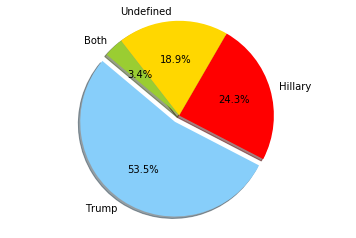

In [71]:
labels = 'Trump', 'Hillary', 'Undefined', 'Both'
sizes = tweets.about.value_counts(dropna=False).tolist()
colors = ['lightskyblue', 'red', 'gold', 'yellowgreen']
explode = (0.08, 0, 0, 0)  # explode Trump slide
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

According to the chart, the majority of the tweets talk about Trump

## Saving the file

In [72]:
tweets.to_pickle("../../data/cp_tweets_classified.pkl")